# UNA INTRODUCCIÓN A CUDA CON PYTHON
[**Miguel Ángel Martínez del Amor**](https://www.cs.us.es/~mdelamor])

*Seminario de Inteligencia Artificial de la Universidad de Sevilla (SIAUS)* 

16 de mayo de 2024

Este notebook es una introducción rápida a cómo usar la GPU desde Python, en concreto mediante CUDA. Nos basaremos en ejemplos sencillos que no conyevan mucha carga computacional, para poder trabajar en ellos en menos de una hora (la duración estimada de esta introducción). Veremos las siguientes tecnologías:
* [CuPy](https://cupy.dev/): alternativa a NumPy para cálculo numérico
* [Numba](https://numba.pydata.org/): compilador de funciones de Python para CPU y GPU con CUDA

## 0. Instalación de CUDA

Las GPUs son dispositivos masivamente paralelos que permiten realizar cálculo numérico de forma eficiente. CUDA es la plataforma de NVIDIA para hacer cómputo paralelo con GPUs (de NVIDIA), el cual está basado en C++ y Fortran. Plataformas para la IA como PyTorch, Tensorflow, RAPIDS, etc. se aceleran en CUDA mediante librerías implementadas en C++ y conectadas con Python a través de extensiones que permiten llamar código C desde Python, como por ejemplo Cython, PyBind11... Por tanto, la programación de la GPU es transparente para nosotros, pudiendo centrarnos en desarrollar soluciones del problema en cuestión. 

Si disponemos de una GPU de NVIDIA, podemos usar CUDA, y para ello necesitamos:
* El driver de NVIDIA. Descargable aquí: https://www.nvidia.com/download/index.aspx
* El driver de CUDA. Disponible en el CUDA toolkit.
* El CUDA toolkit. Descargable [aquí](https://developer.nvidia.com/cuda-downloads). 

En distribuciones de Linux como Ubuntu o Rocky, todo lo anterior se puede instalar fácilmente con `apt install cuda` o `dnf install cuda` (respectivamente), después de añadir el feed del repositorio de NVIDIA.

Una forma de comprobar que el driver está bien instalado es ejecutando la siguiente instrucción. Ésta es, además, la instrucción más usada para comprobar el estado de nuestras GPUs (cantidad de memoria consumida, temperatura, porcentaje de uso, etc)

In [1]:
!nvidia-smi

Wed May 15 12:33:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080         Off| 00000000:01:00.0 Off |                  N/A |
|  0%   42C    P8                8W / 265W|     15MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Si tienes varias GPUs, puedes elegir una de ellas con la variable de entorno `CUDA_VISIBLE_DEVICES` e indicando el id de la GPU (el número que aparece a la izquierda en la salida de la instrucción anterior). Por ejemplo, en mi caso voy a seleccionar la RTX3090 que tenemos en el servidor mulhacen del [RGNC](https://www.gcn.us.es/gpucomputing).

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Lo anterior afectará al código CUDA que hagamos, ya que solo verá la GPU 1. Sin embargo, `nvidia-smi` es parte del driver de NVIDIA y sigue viendo todas las GPUs del sistema.

## 1. Introducción a CuPy

A la hora de usar una GPU siempre hay que tener en mente que hacemos uso de un dispositivo distinto a la CPU, por tanto es bueno tener en cuenta los siguientes puntos (algunos de los "mandamientos del GPU computing", como vimos en el [seminario "GPU computing for Machine Learning"](https://www.cs.us.es/investigacion/seminario-de-inteligencia-artificial/2024-03-07-gpu-computing-for-machine-learning)):
1. La GPU es otro dispositivo, y necesita recibir los datos a procesar. Ese traspaso hacia y desde la GPU requiere tiempo, por tanto hay que minimizar, dentro de lo posible, la transferencia de datos.
2. La GPU es buena para paralelismo de datos, por tanto es bueno hacer operaciones tipo map (transformación de datos), reducción (suma, producto, media, máximo, etc.), prefix sum (compactación de datos, ordenación, etc.), histogramas, etc. Todo esto ya está muy bien estudiado, se conocen como primitivas.
3. La GPU es buena para cálculo numérico, como álgebra lineal, sobre todo en vectores y matrices. Aunque hay librerías para trabajar con cadenas (cuString), es mejor usar valores numéricos (enteros, punto flotante), y disponerlos en arrays (vectores, matrices, tensores...).

Una librería que aglutina muy bien los tres puntos comentados es CuPy. Es una librería de Python que clona la API de NumPy y SciPy, por lo que el código que ya tengas en estas librerías más clásicas debería funcionar con tan solo cambiar el import (en teoría...). Esta es la forma sencilla de programar con GPUs, por lo que vamos a comenzar por aquí. Veamos una primera aproximación implementando un sencillo algoritmo de procesamiento de imágenes: pasar a escala de grises una imagen de color. Primero, descarguemos una imagen 1320x1920 de un perrito:

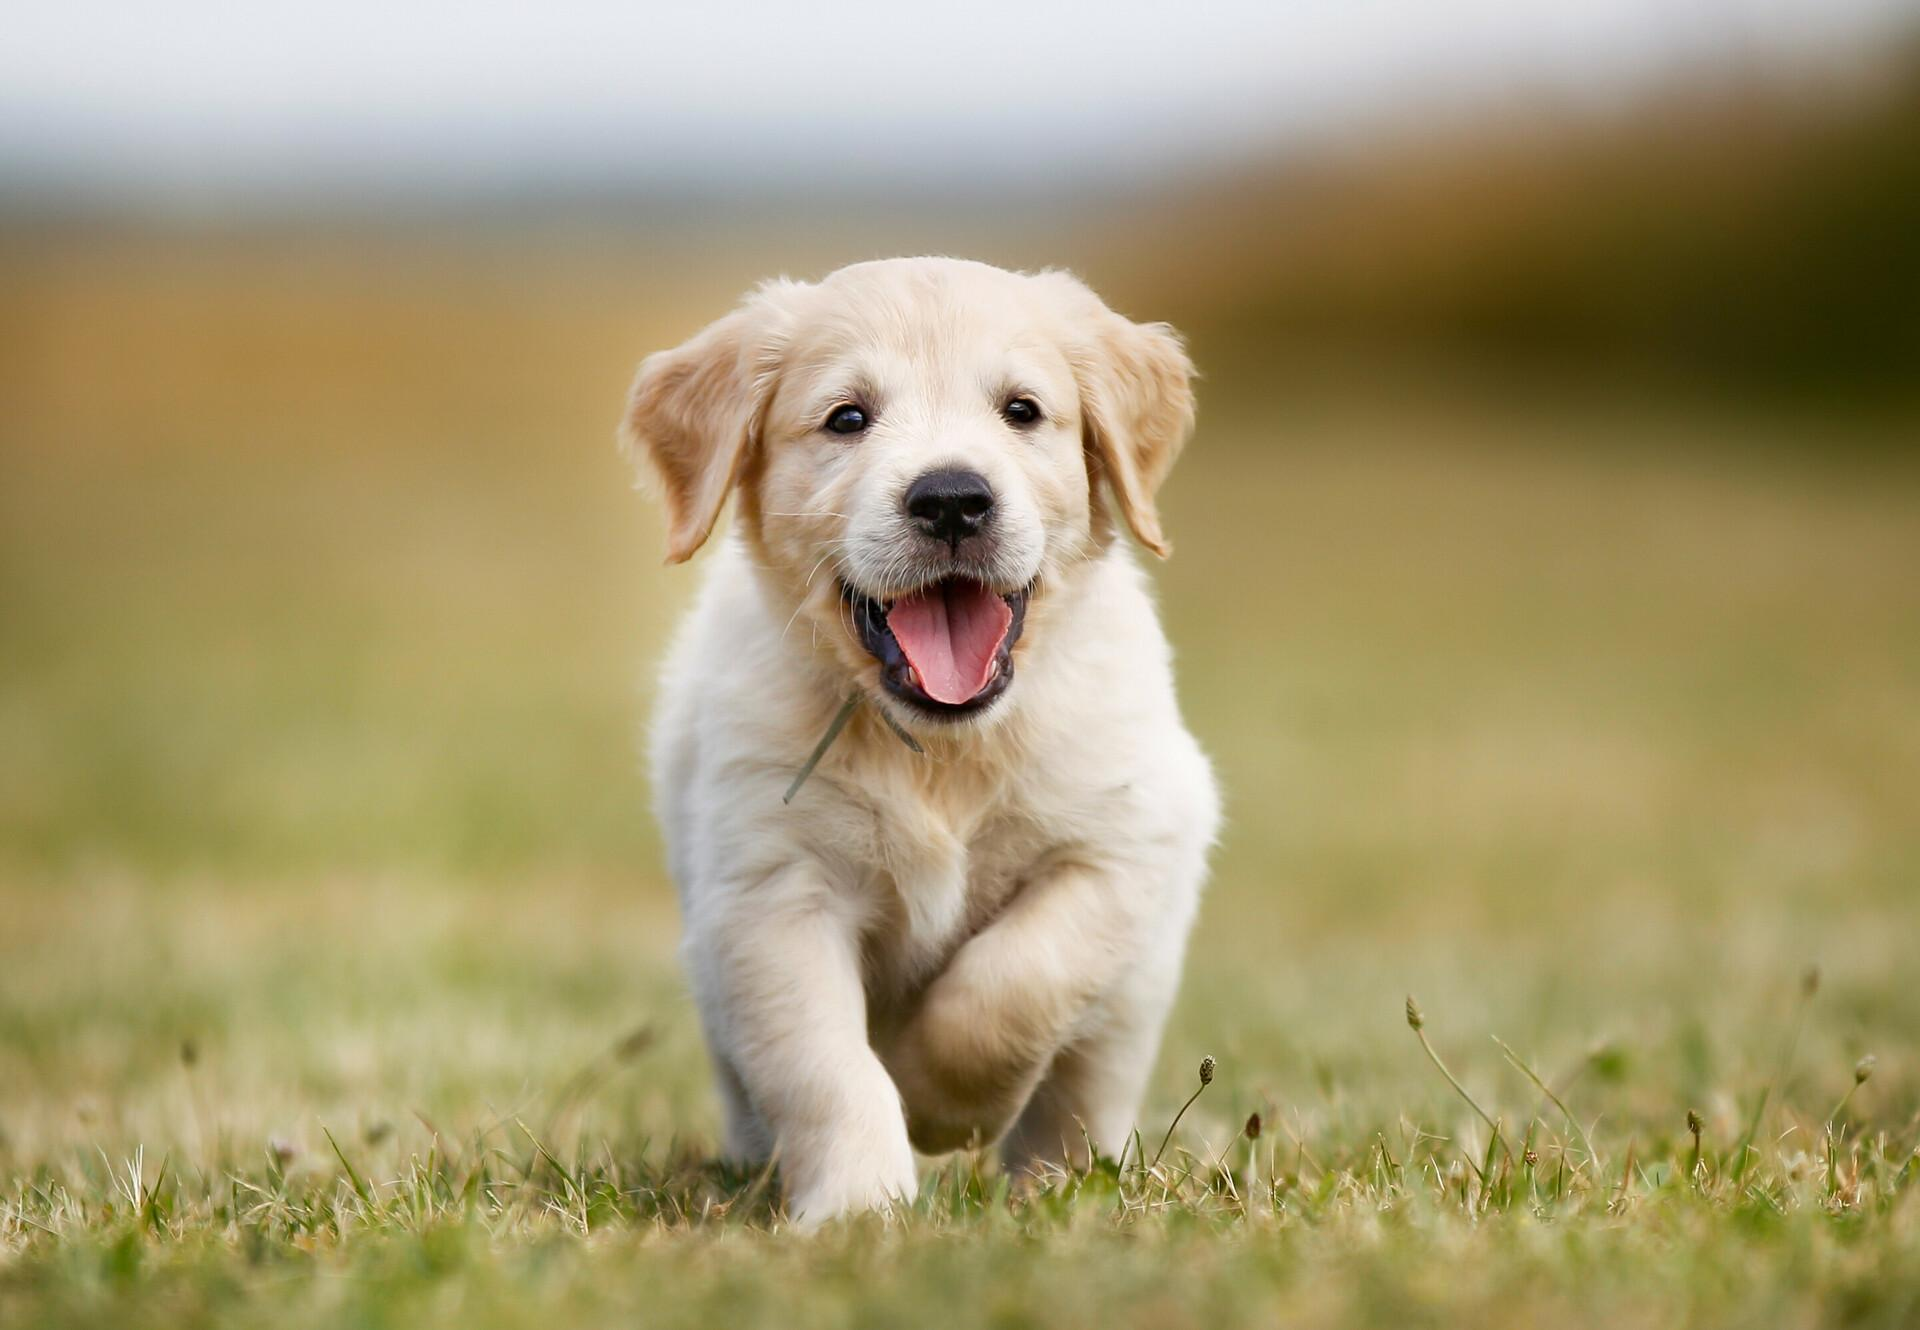

In [3]:
import urllib.request
from PIL import Image

# Descargamos una imagen, por ejemplo esta de un perrito
url = "https://raw.githubusercontent.com/cuda-mode/lectures/main/lecture_003/puppy.jpg"
urllib.request.urlretrieve(url, "puppy.jpg")

# Abrimos la imagen descargada y la mostramos
img = Image.open(r"puppy.jpg")
img

### 1.1 Numpy

Numpy es una librería que nos permite trabajar con arrays (de cualquier dimensionalidad) de forma sencilla. Por ejemplo, carguemos la imagen en Numpy:

In [4]:
import numpy as np

nimg = np.array(img,dtype='uint8')

print(nimg.shape)

nimg

(1330, 1920, 3)


array([[[225, 228, 233],
        [225, 228, 233],
        [225, 228, 233],
        ...,
        [160, 159, 155],
        [159, 158, 154],
        [159, 158, 154]],

       [[225, 228, 233],
        [225, 228, 233],
        [225, 228, 233],
        ...,
        [159, 158, 154],
        [159, 158, 154],
        [159, 158, 154]],

       [[225, 228, 233],
        [225, 228, 233],
        [225, 228, 233],
        ...,
        [158, 157, 153],
        [158, 157, 153],
        [158, 157, 153]],

       ...,

       [[123, 114,  57],
        [124, 115,  58],
        [125, 116,  57],
        ...,
        [ 97,  91,  39],
        [ 98,  92,  40],
        [ 98,  92,  40]],

       [[125, 119,  61],
        [125, 119,  61],
        [125, 119,  61],
        ...,
        [ 97,  91,  41],
        [ 97,  91,  41],
        [ 98,  92,  42]],

       [[125, 119,  61],
        [125, 119,  61],
        [125, 119,  61],
        ...,
        [ 97,  91,  41],
        [ 97,  91,  41],
        [ 98,  92,  42]]

Hay muchas formas de hacer este algoritmo, el cual requiere computar, para cada canal de color de cada pixel (Rojo, Verde y Azul), la siguiente fórmula (según NTSC): `0.2989*Azul + 0.5870*Verde + 0.1140*Rojo`. Empecemos sacando los tres canales de color por separado como arrays independientes:

In [5]:
b, g, r    = nimg[:, :, 0], nimg[:, :, 1], nimg[:, :, 2] # For RGB image

Finalmente hagamos el cálculo en Numpy como un cálculo de arrays. Esto hará el cálculo elemento a elemento.

**CUIDADO!** Mucho ojo con el tipo de datos. El array de la imagen es un enterno sin precisión de 8 bits, suficiente para tener valores de 0 a 255. Sin embargo, por defecto, Python hará la conversión de tipos a 64 bits (doble precisión) en el siguiente cálculo, lo cual es demasiado para este problema y hará que todo vaya mucho más lento. Usemos precisión simple haciendo un casting de tipos a las constantes. **Siempre hay que llevar cuidado con el tipo de datos de nuestros arrays, sobre todo para GPU**.

Vamos a uasr `%timeit` para ejecutarlo varias veces y ver el tiempo que requiere en Numpy esta transformación:

In [6]:
%timeit gray_np = np.float32(0.2989)*b + np.float32(0.5870)*g + np.float32(0.1140)*r

7.31 ms ± 24.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
# como la línea anterior solo evalúa el tiempo, no define el resultado, hagamos de nuevo el cálculo sin medir tiempo
gray_np = np.float32(0.2989)*b + np.float32(0.5870)*g + np.float32(0.1140)*r

Hagamos por ejemplo un cálculo de reducción, como por ejemplo calcular el valor máximo:

In [8]:
%timeit gray_np.max()

274 µs ± 221 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Veamos qué tal ha quedado el resultado:

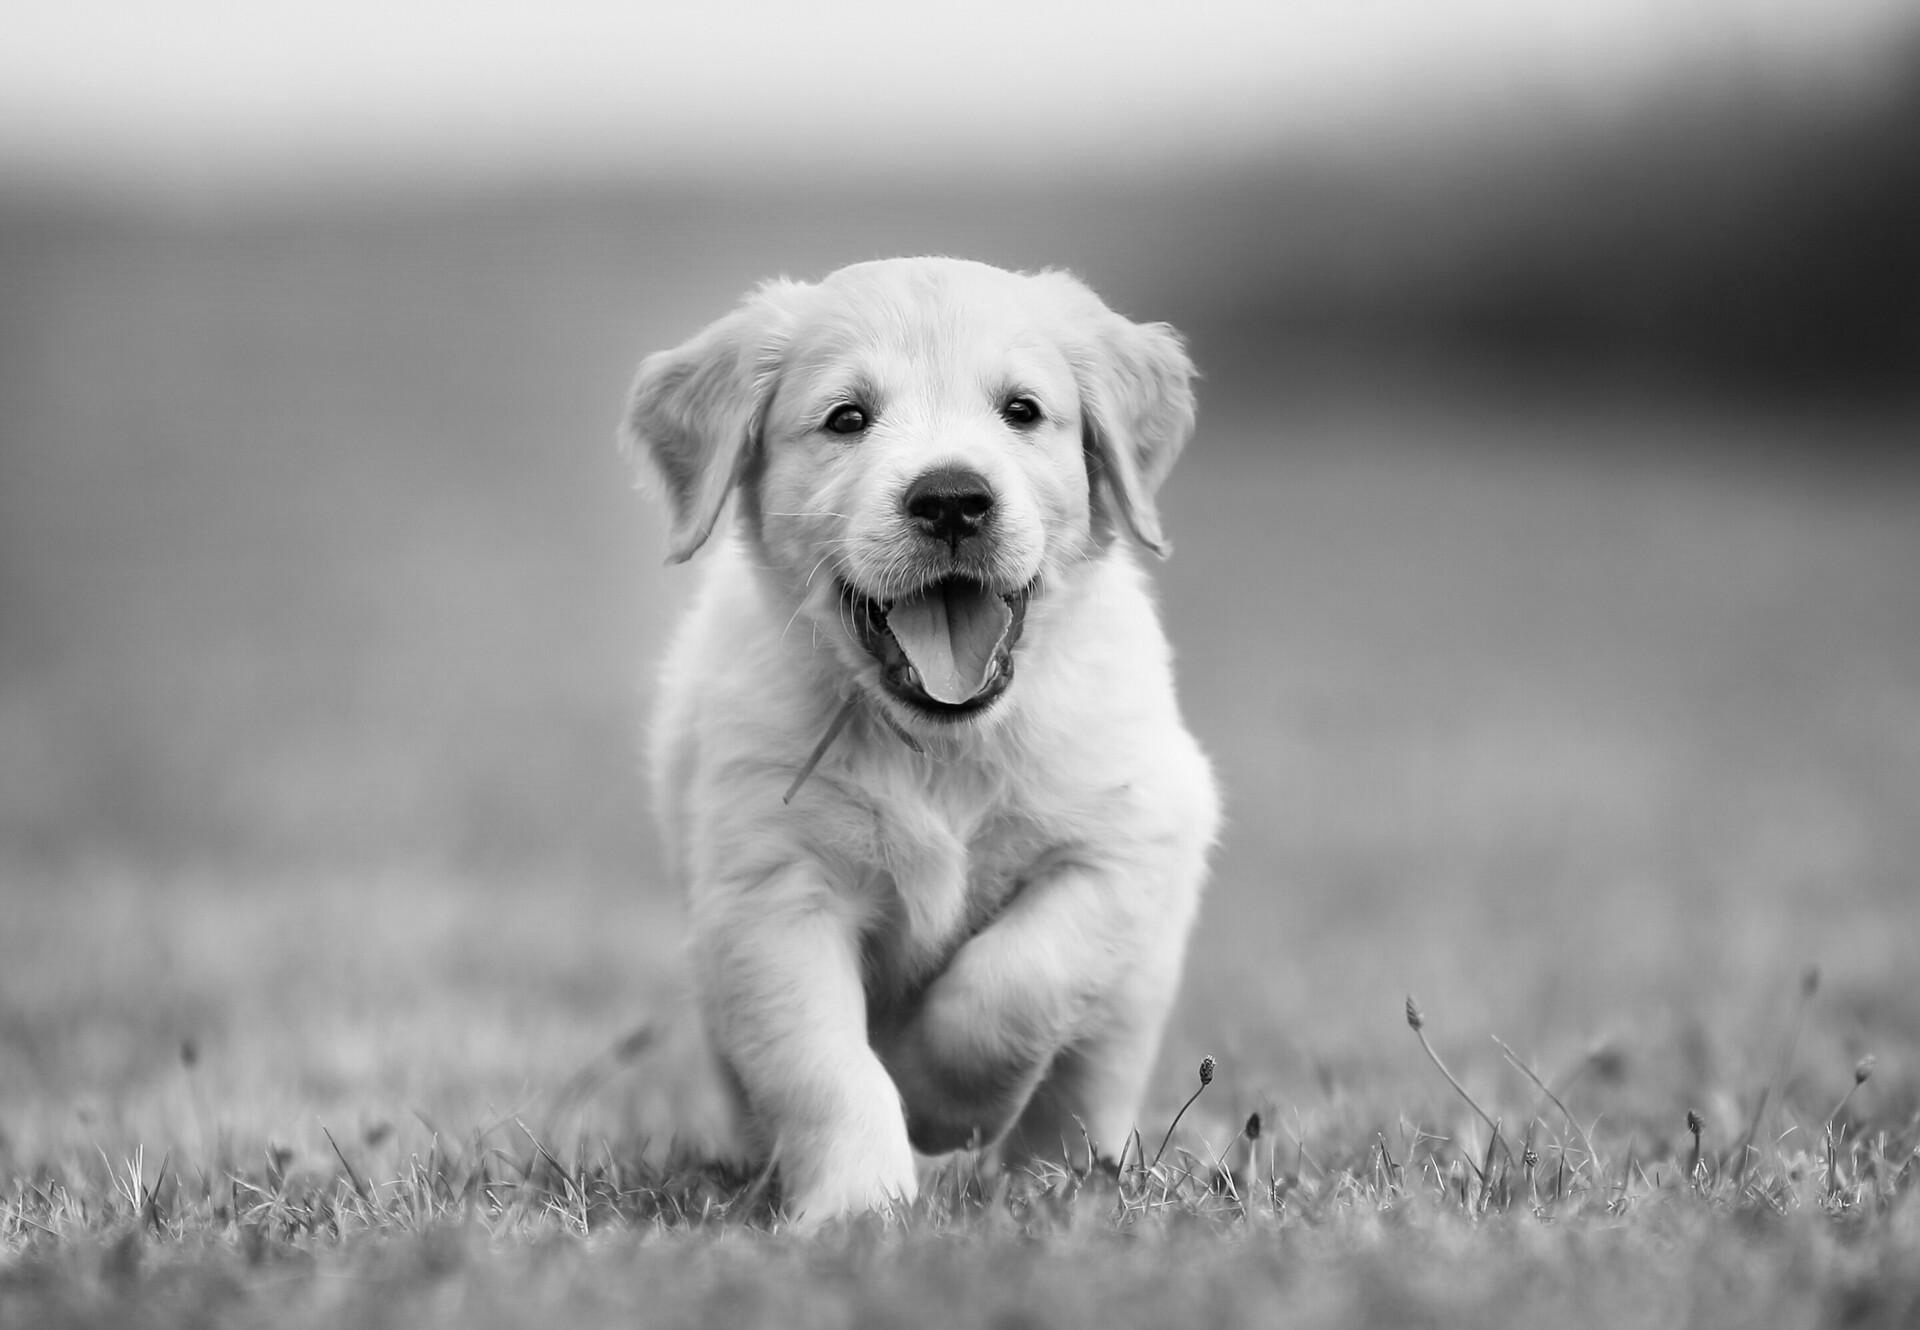

In [9]:
Image.fromarray(gray_np.astype(np.uint8))

### 1.2 CuPy

Ahora hagamos lo mismo con [Cupy](https://cupy.dev/), primero importemos la librería. La instalación es sencilla, siguiendo [estos pasos](https://docs.cupy.dev/en/stable/install.html). Requiere tener CUDA instalado en el sistema, por supuesto. También da sorporte para ROCm, es decir, la plataforma de GPUs de AMD.

In [10]:
import cupy as cp

La variable `nimg` está en la CPU, y por tanto la GPU no puede acceder. Hay que crear un array de cupy, que tendrá los datos en el dispositivo paralelo. Una forma es copiar un array de numpy a la GPU mediante la función `asarray`.

In [11]:
d_nimg = cp.asarray(nimg)

La extracción de los canales de color la podemos hacer igual que como hicimos en Numpy, la API es la misma!

In [12]:
d_b, d_g, d_r  = d_nimg[:, :, 0], d_nimg[:, :, 1], d_nimg[:, :, 2]

Y por tanto el cálculo es igual. Verás que el tiempo de ejecución baja drásticamente (dependiendo de tu GPU):

In [13]:
%timeit gray_cp = cp.float32(0.2989)*d_b + cp.float32(0.5870)*d_g + cp.float32(0.1140)*d_r

149 µs ± 48.5 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [14]:
# como la línea anterior solo evalúa el tiempo, no define el resultado, hagamos de nuevo el cálculo sin medir tiempo
gray_cp = cp.float32(0.2989)*d_b + cp.float32(0.5870)*d_g + cp.float32(0.1140)*d_r

Lo mismo para calcular el valor máximo

In [15]:
%timeit gray_cp.max()

18.4 µs ± 15.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Sin embargo el resultado está en la GPU, y no podemos verlo. Para ello, debemos transferir el resultado de vuelta a la CPU, que es la que está ejecutando este notebook. Una forma es pasarlo a un array de Numpy mediante la función `asnumpy`:

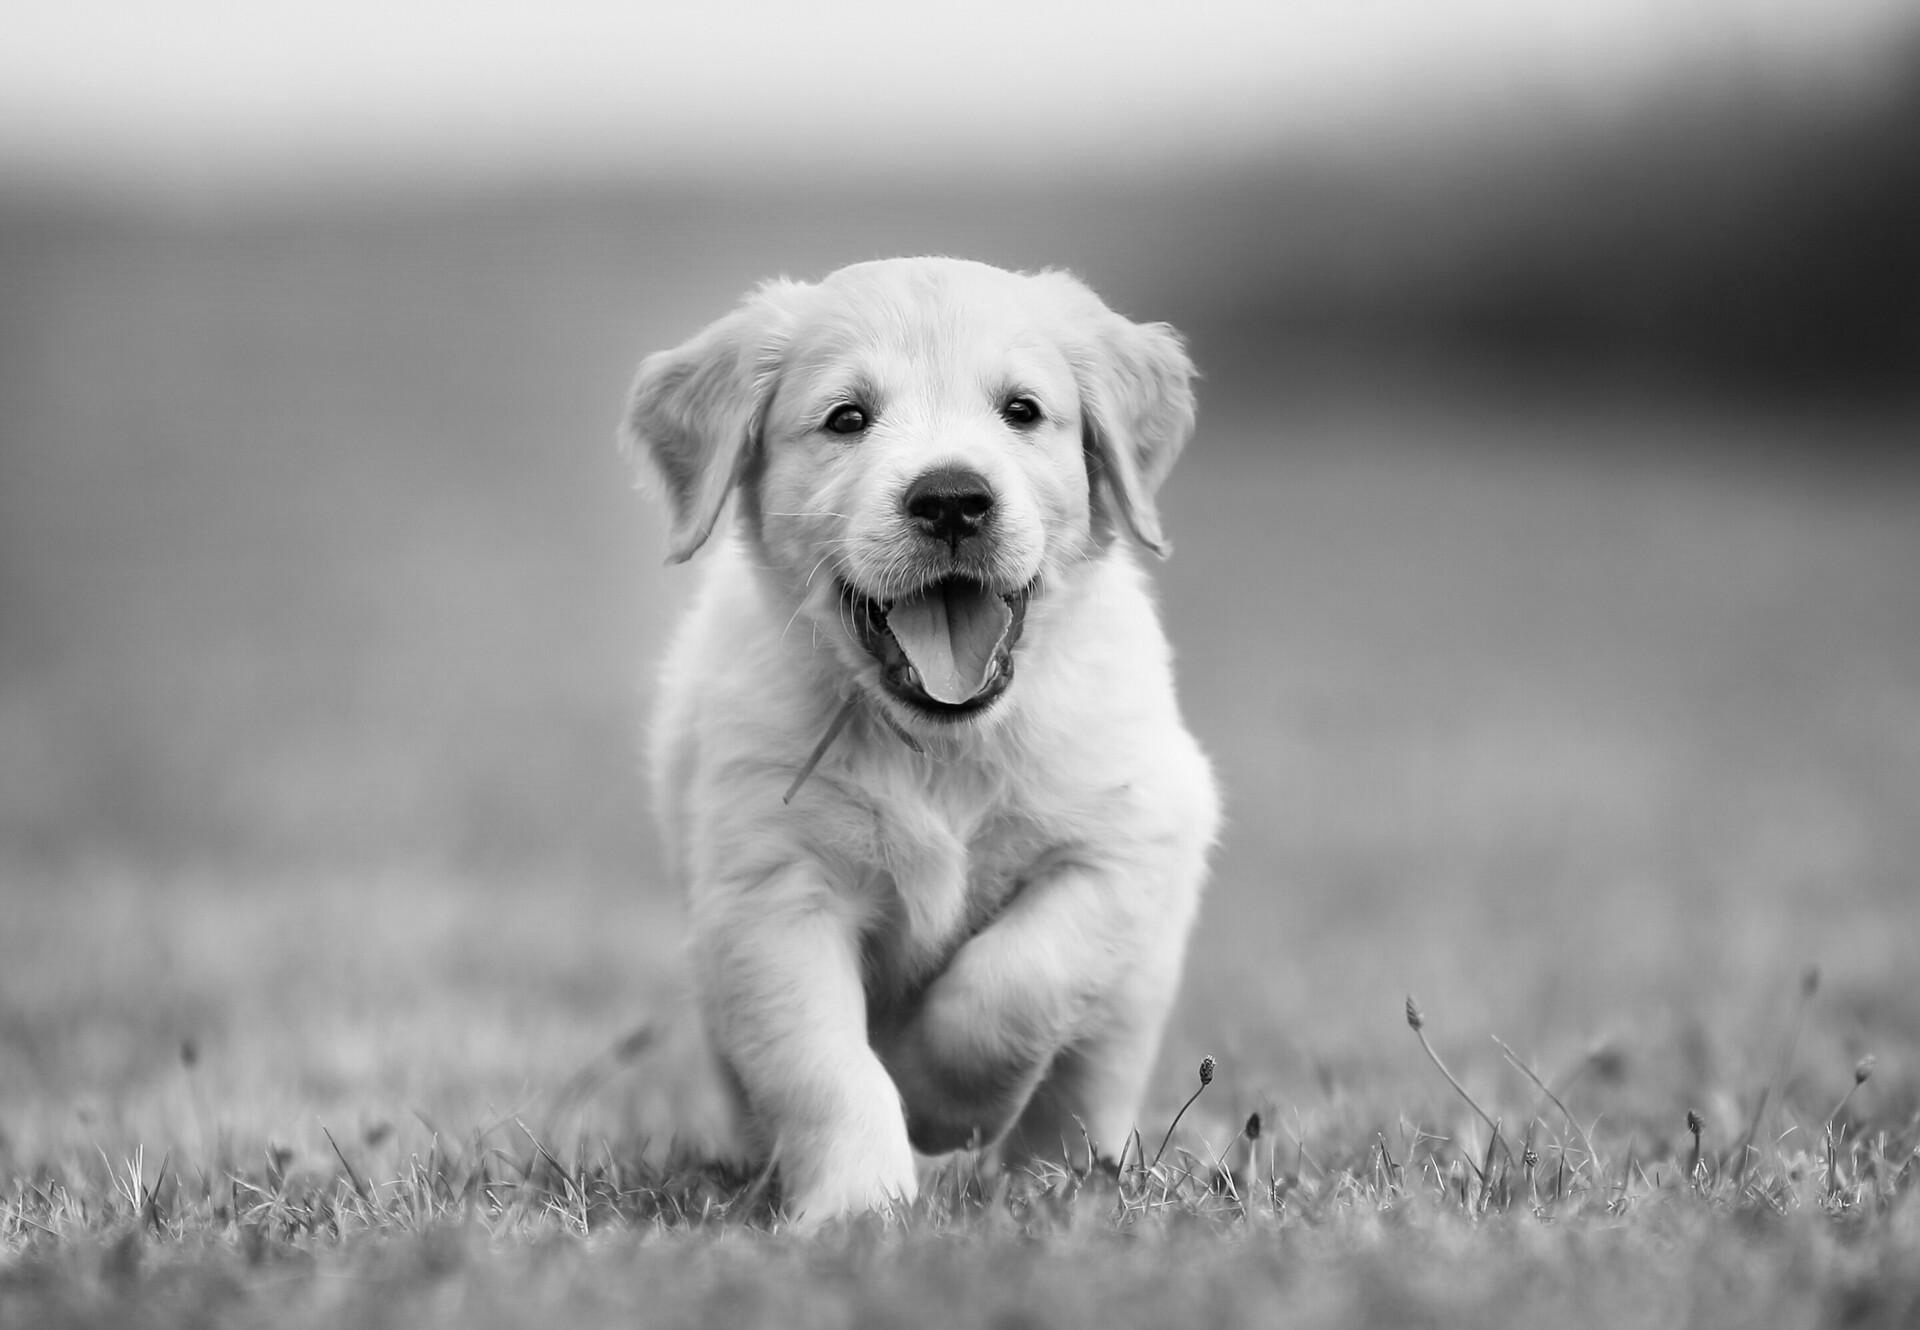

In [16]:
h_gray_cp = cp.asnumpy(gray_cp)
Image.fromarray(h_gray_cp.astype(np.uint8))

En conclusión. Si ya trabajáis con Numpy y necesitáis acelerar cálculos, o bien tenéis un código de Machine Learning en GPU y queréis hacer transformaciones a los datos en la GPU para evitar el traspaso de datos, CuPy es una buena alternativa. Tiene una curva de aprendizaje nula, ya que es la misma API que Numpy, y es compatible con la mayoría de librerías de Machine Learning, sobre todo con RAPIDS. 

Llegados a este punto, hay varias formas de proceder:
* ¿Necesitas tratar datos en formato de tabla/dataframe? Usa cuDF, la librería de [RAPIDS](https://rapids.ai/) que clona la API de Pandas.
* ¿Necesitas implementar un código mucho más elaborado que lo que puedes hacer con Numpy/cuPY? Entonces convendría implementar nuestros propios Kernels (código que se ejecuta en la GPU). Hay varias formas:
  * **Kernels en CuPy**: Esta libería permite implementar nuestros propios kernels con un lenguaje específico y basado en C++, como se puede ver [aquí](https://docs.cupy.dev/en/stable/user_guide/kernel.html).
  * **Compilación en Python mediante Numba**. Esta es la mejor alternativa si no queréis salir de Python y no tocar nada de código C++, y es la que veremos a continuación.
  * **Compilación de CUDA C++ desde Python**: existen muchas formas de compilar kernels de CUDA escritos en C++ (el lenguaje oficial, donde todas las características de CUDA, incluyendo las nuevas, están solo disponibles) desde Python. Estas librerías permiten la compilación así como hacer uso de los kernels desde Python, es decir, el código Host es Python y el código device (el kernel) es C++:
     * [CUDA Python](https://developer.nvidia.com/blog/unifying-the-cuda-python-ecosystem/): El wrapper oficial de NVIDIA para hacer llamadas desde Python a la API de CUDA
     * Compilación de kernels en línea con PyTorch mediante la función `load_inline`. Una buena introducción es la que hicieron en [CUDA Mode](https://github.com/cuda-mode/lectures/tree/main/lecture_003), en la cual me he basado para este mini-tutorial. 
     * [PyCUDA](https://documen.tician.de/pycuda/): un wrapper con mucho recorrido, quizás el primero que permitía hacer uso de CUDA desde Python, y que sigue estando disponible.
     * Compilación en C++ y conexión mediante [PyBind11](https://pytorch.org/tutorials/advanced/cpp_extension.html) (como hace PyTorch para sus extensiones CUDA) o Cython (como hace RAPIDS para todas sus librerías).
     * [Tensorflow](https://www.tensorflow.org/guide/create_op?hl=es) también permite crear nuevas operaciones con CUDA, aunque tiene pinta ser algo más lioso que con PyTorch.
  

## 2. Introducción a Numba

### 2.1. ¿Qué es Numba?

[Numba](http://numba.pydata.org/) es un **compilador de funciones ("function compiler")**, **justo-en-el-momento ("just-in-time")**, y **especializador de tipos ("type-specializing")** para acelerar Python **enfocado numéricamente ("numerically-focused")**. Esto es una lista larga, rompamos esto en los siguientes términos:

 * **function compiler**: Numba compila funciones de Python, no aplicaciones enteras ni partes de funciones.  Numba no reemplaza tu intérprete de Python, es tan solo otro módulo de Python que puede convertir tu función en otra (usualmente) más rápida. 
 * **type-specializing**: Numba acelera tu función generando una implementación especializada para los tipos de datos específicos que está utilizando.  Las funciones de Python están diseñadas para funcionar con tipos de datos genéricos, lo que las hace muy flexibles, pero también muy lentas.  En la práctica, uno solo llama a una función con un pequeño número de tipos de argumentos, por lo que Numba generará una implementación rápida para cada conjunto de tipos.
 * **just-in-time**: Numba traduce las funciones cuando se llaman por primera vez.  Esto asegura que el compilador sepa qué tipos de argumentos va a usar.  Esto también permite que Numba sea usado interactivamente en un cuaderno Jupyter tan fácilmente como una aplicación tradicional.
 * **numerically-focused**: Actualmente, Numba se centra en los tipos de datos numéricos, como `int`, `float`, y `complex`.  El soporte para el procesamiento de cadenas es muy limitado, y en muchos casos el uso de cadenas no funciona bien en la GPU.  Para obtener los mejores resultados con Numba, es probable que utilices los arrays de NumPy.

### 2.2. Primeros Pasos

Escribamos nuestra primera función Numba y compilémosla para 
la **CPU**. El compilador de Numba se habilita típicamente aplicando un *decorador* a la función Python. Los decoradores son funciones que transforman funciones de Python. Aquí usamos el decorador para compilación CPU:

In [17]:
from numba import jit
import math

@jit
def hypot(x, y):
    # Implementación de https://en.wikipedia.org/wiki/Hypot
    x = abs(x);
    y = abs(y);
    t = min(x, y);
    x = max(x, y);
    t = t / x;
    return x * math.sqrt(1+t*t)

El código anterior es equivalente a escribir:

``` python
def hypot(x, y):
    x = abs(x);
    y = abs(y);
    t = min(x, y);
    x = max(x, y);
    t = t / x;
    return x * math.sqrt(1+t*t)
    
hypot = jit(hypot)
```

Esto significa que el compilador de Numba es tan solo una función que puedes llamar siempre que quieras. Probemos nuestro cálculo de la hipotenusa:

In [18]:
hypot(3.0, 4.0)

5.0

La primera vez que llamamos a `hypot`, el compilador se lanza y compila una implementación de código máquina para las entradas de tipo float. Numba también salva la función Python original en el atributo `.py_func`, así que podemos llamar la código Python original para asegurarnos que obtenemos la misma respuesta:

In [19]:
hypot.py_func(3.0, 4.0)

5.0

Numba no puede compilar todo el código Python.  Algunas funciones no tienen una traducción de Numba, y algunas clases de tipos Python no pueden ser compilados eficientemente (todavía).  Por ejemplo, Numba no soporta diccionarios:

In [20]:
@jit
def cannot_compile(x):
    return x['key']

cannot_compile(dict(key='value'))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
During: typing of argument at /tmp/ipykernel_191395/391980188.py (1)

File "../../../../tmp/ipykernel_191395/391980188.py", line 1:
<source missing, REPL/exec in use?> 

This error may have been caused by the following argument(s):
- argument 0: Cannot determine Numba type of <class 'dict'>


### 2.3 Funciones vectorizadas y copia de datos a la GPU

Estas funciones son una forma rápida de usar la GPU en Numba, ya que no requiere escribir código Kernel y trabaja directamente sobre arrays de Numpy. Sin embargo, no nos detendremos demasiado en este mini-tutorial, ya que todo lo que se puede hacer con la vectorización se puede hacer con CuPy, y es mucho más sencillo. Sin embargo, si te interesa, puedes ver cómo usarlo en este [tutorial de CUDA Numba](https://github.com/miguelamda/cuda-numba).

Veamos rápidamente cómo cambia el decorador para indicar que queremos ejecutar una función en la GPU, y esta operación se de aplicar elemento a elemento al vector que después se indique. En el decorador hay que declarar los tipos de los datos: `salida(entrada1, entrada2, entrada3...)`:

In [21]:
from numba import vectorize
import numpy as np

@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y

Numba trabaja perfectamente con Numpy, pero como hemos comentado, estos datos residen en la CPU. Si usas código CUDA de Numba sobre un Numpy array, no te preocupes, funcionará:

In [22]:
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x

In [23]:
%timeit add_ufunc(x, y)  # Rendimiento base con dos arrays en host

813 µs ± 345 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Sin embargo, la copia hacia y desde la GPU será transparente para nosotros, por lo que puede que no sea lo más eficiente ya que las siguientes llamadas a Kernel sobre los mismos datos de nuevo copiarán los datos. Es mejor transferirlos a la GPU de manera explícita, y esto se hace con lo siguiente:El módulo `numba.cuda` incluye una función que copiará datos de host a la GPU y devolverá un array en device de CUDA.

In [24]:
from numba import cuda

x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

print(x_device)
print(x_device.shape)
print(x_device.dtype)

(100000,)
float32


Los arrays device pueden ser pasados a funciones CUDA como si fuesen arrays de NumPy, pero sin la sobrecarga de copia:

In [25]:
%timeit add_ufunc(x_device, y_device)

268 µs ± 504 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Es una gran mejora de rendimiento, pero aún estamos asignando un array device para la salida del ufunc y copiándolo de nuevo al host.  Podemos crear el búfer de salida con la función `numba.cuda.device_array()`:

In [26]:
out_device = cuda.device_array(shape=(n,), dtype=np.float32)  # no incluye contenidos de inicialización, como np.empty()

Ahora podemos usar un argumento especial con el keyword `out` en la llamada a la ufunc, para especificar el buffer de salida:

In [27]:
%timeit add_ufunc(x_device, y_device, out=out_device)

172 µs ± 140 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Ahora que hemos eliminado los pasos de reserva y copia de memoria en device, el cálculo se ejecuta *mucho* más rápido que antes.  Cuando queramos devolver el array de vuelta a la memoria del host, podemos usar el método `copy_to_host()`:

In [28]:
out_host = out_device.copy_to_host()
print(out_host[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


### 2.4 Kernels de CUDA

Para escribir código CUDA hay que recordar el modelo de programación, lo cual conyeva a entender la jerarquía de hilos siguiente:

![Jerarquía de Hilos](https://docs.nvidia.com/cuda/cuda-c-programming-guide/_images/grid-of-thread-blocks.png)

Escribiremos un *kernel* que describe la ejecución de un único hilo en esta jerarquía.  El compilador y el controlador CUDA ejecutarán nuestro kernel a través de un *grid de hilos* que está dividida en *bloques* de hilos.  Los hilos dentro del mismo bloque pueden intercambiar datos muy fácilmente durante la ejecución de un kernel, mientras que los hilos en bloques diferentes generalmente no deberían comunicarse entre sí (con algunas excepciones).

Decidir cuál es el mejor tamaño para el grid de hilos CUDA es un problema complejo (y depende tanto del algoritmo como de la capacidad de cálculo específica de la GPU), pero a continuación se indican algunas heurísticas muy aproximadas que solemos seguir:

  * el tamaño de un bloque debe ser múltiplo de 32 hilos, con tamaños de bloque típicos entre 128 y 512 hilos por bloque.
  * El tamaño del grid debe garantizar la utilización de toda la GPU en la medida de lo posible.  Un buen punto de partida es lanzar un grid en la que el número de bloques sea de 2 a 4 veces el número de «multiprocesadores» de la GPU.  Algo entre 20 y 100 bloques suele ser un buen punto de partida.  
  * La sobrecarga de lanzamiento del kernel CUDA depende del número de bloques, por lo que nos parece mejor no lanzar un grid en el que el número de hilos sea igual al número de elementos de entrada cuando el tamaño de la entrada sea muy grande. 

Cada hilo se distingue de los otros hilos usando sus valores únicos de índice de hilo (`threadIdx`) y bloque (`blockIdx`), que pueden ser multidimensionales si se lanzan así.

Empecemos de forma sencilla, hagamos un kernel que lo único que haga sea sumar dos vectores. Los kernels de CUDA kernels se compilan usando el decorador `numba.cuda.jit` (no confundir con `numba.jit`  para la CPU):

In [29]:
from numba import cuda

@cuda.jit
def add_kernel(x, y, out): # El nombre de los parámetros lo ponemos nosotros
    tx = cuda.threadIdx.x # Este es el ID de hilo dentro del bloque
    ty = cuda.blockIdx.x  # Este es el ID del bloque dentro del grid

    block_size = cuda.blockDim.x  # número de hilos por bloque
    grid_size = cuda.gridDim.x    # número de bloques por grid
    
    start = tx + ty * block_size
    stride = block_size * grid_size

    # asumiendo que x e y son entradas de la misma longitud:
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]

Los Kernels nunca devuelven valores, ya que asume que los resultados se deben escribir en la memoria de la GPU. Además, el nombre de los parámetros lo ponemos nosotros, que el vector de salida se llame `out` es porque hemos querido, no hay una convención como hemos visto en la vectorización. Tampoco es obligatorio poner el vector de salida al final, es simplemente el orden que hemos establecido en el ejemplo.

El patrón de cálculo de un índice inicial y un stride es una forma habitual de garantizar que el tamaño del grid es independiente del tamaño de la entrada. El striding maximizará el ancho de banda asegurando que los hilos con índices consecutivos accedan a posiciones de memoria consecutivas tanto como sea posible. En la siguiente figura se puede observar que hay muchos menos hilos que elementos de entrada, primero trabajan sobre una porción (en rosa) y después todos van iterando (el stride). Esta técnica también se conoce como *tiling*, y permite maximizar el trabajo de los hilos.

![striding](https://alexminnaar.com/assets/grid_stride.png)

Los hilos con índices superiores a la longitud de la entrada (`x.shape[0]`, ya que `x` es un array de NumPy) se saltan automáticamente el bucle `for` y acaban. Observa también que no necesitamos especificar el tipo de las entradas para el kernel de CUDA.  A diferencia de `@vectorize`, Numba puede inferir el tipo a partir de las entradas automáticamente, y de forma mucho más fiable.

Llamemos ahora a la función sobre algunos datos, verás que la llamada también cambia:

In [30]:
import numpy as np

n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x
out = np.empty_like(x)

threads_per_block = 128
blocks_per_grid = 30

add_kernel[blocks_per_grid, threads_per_block](x, y, out)
print(out[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


/usr/local/lib64/python3.9/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 30 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib64/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


En últimas versiones de Numba veras algunos warnings que indican problemas de eficiencia (oportunidades de optimización de código). 

La inusual sintaxis para llamar a la función del kernel está diseñada para imitar la API de tiempo de ejecución de CUDA en C, donde la llamada anterior se vería como:
```
add_kernel<<blocks_per_grid, threads_per_block><>(x, y, out)
```
Los argumentos entre corchetes definen el tamaño y la forma del grid de hilos, y los argumentos entre paréntesis corresponden a los argumentos de la función kernel.

Los argumentos se pasan al kernel como matrices NumPy completas. El kernel puede acceder a cualquier elemento del array que desee, independientemente de su posición en el thread grid, lo cual abre toda la potencia de la GPU y lo pone a nuestro alcance.

Ahora hagamos uso de los datos copiados a la GPU:

In [31]:
x_device = cuda.to_device(x)
y_device = cuda.to_device(y)
out_device = cuda.device_array_like(x)

In [32]:
%timeit add_kernel[blocks_per_grid, threads_per_block](x, y, out)

1.19 ms ± 3.78 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [33]:
%timeit add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device); out_device.copy_to_host()

169 µs ± 144 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Finalmente, veamos una simplificación que añade Numba a CUDA, y es que el cálculo de los índices de los hilos a nivel global ya viene dado por unas funciones especiales. Fíjate cómo queda ahora el kernel:

In [34]:
@cuda.jit
def add_kernel(x, y, out):
    start = cuda.grid(1)      # Devuelve el ID de hilo a nivel global (no del bloque).
                              # Como tenemos un grid de hilos unidimensional, devuelve solo un valor
    stride = cuda.gridsize(1) # Devuelve el tamaño del grid

    # como antes
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]

### 2.5 Sincronización de kernel

*Aquí se debe mencionar una advertencia extremadamente importante*: La ejecución del kernel CUDA está diseñada para ser asíncrona con respecto al programa anfitrión.  Esto significa que el lanzamiento del kernel (`add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device)`) retorna inmediatamente, permitiendo a la CPU seguir ejecutando mientras la GPU trabaja en segundo plano. Sólo las copias de memoria host<->dispositivo o una llamada de sincronización explícita obligarán a la CPU a esperar hasta que se completen los kernels CUDA previamente puestos en cola.

Cuando pasas arrays NumPy de host a un kernel CUDA, Numba tiene que sincronizarse en su nombre, pero si pasas arrays de dispositivo, el procesamiento continuará.  Si lanzas múltiples kernels en secuencia sin ninguna sincronización entre ellos, se pondrán en cola para ser ejecutados secuencialmente por el driver, que es normalmente lo que quieres.  Si quieres ejecutar varios kernels en paralelo en la GPU (a veces es una buena idea, pero ten cuidado con las condiciones de carrera), echa un vistazo a [CUDA streams](http://numba.pydata.org/numba-doc/dev/cuda-reference/host.html?highlight=synchronize#stream-management).

Aquí tienes algunos ejemplos de tiempos (usando `%time`, que sólo ejecuta la sentencia una vez para asegurar que nuestra medida no se ve afectada por la profundidad finita de la cola del kernel CUDA):

In [35]:
# CPU input/output arrays, sincronización implícita en la copia de memoria
%time add_kernel[blocks_per_grid, threads_per_block](x, y, out)

CPU times: user 41.5 ms, sys: 1.04 ms, total: 42.5 ms
Wall time: 42.1 ms


/usr/local/lib64/python3.9/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 30 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib64/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [36]:
# GPU input/output arrays, sin sincronización en la medida del tiempo (forzado antes y después de la llamada)
cuda.synchronize()
%time add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device)
cuda.synchronize()

CPU times: user 146 µs, sys: 0 ns, total: 146 µs
Wall time: 144 µs


In [37]:
# GPU input/output arrays, incluyendo sincronización explícita en la medida de tiempo
cuda.synchronize()
%time add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device); cuda.synchronize()

CPU times: user 174 µs, sys: 14 µs, total: 188 µs
Wall time: 119 µs


### 2.6 Más sobre CUDA Numba

No nos dará tiempo de cubrir más elementos de CUDA, como por ejemplo la sincronización de hilos dentro de un bloque, o las operaciones atómicas para asegurar la sobreescritura de memoria sin condiciones de carrera. Tampoco veremos cómo depurar código, etc. Todo esto lo podéis ver en tutoriales como [éste](https://github.com/miguelamda/cuda-numba), [éste](https://github.com/numba/nvidia-cuda-tutorial) o en el [curso oficial de 8 horas del NVIDIA deep learning institute](https://learn.nvidia.com/courses/course-detail?course_id=course-v1:DLI+S-AC-10+V1). Si te interesa este último curso, contacta conmigo para obtener acceso a él.

## 3. Ejercicio propuesto 1

### 3.1. Kernel para transformar imágenes a escala de grises

Hagamos un Kernel que haga la conversión a escala de grises de la imagen del perrito que hemos usado antes. Primero, vamos a factorizar un poco el código, y de camino aprenderemos algo nuevo. 

Los Kernels son funciones del dispositivo (GPU) que se ejecuta desde la CPU. También es posible tener funciones del dispositivo que se llama desde el dispositivo (por ejemplo desde un Kernel), y estas funciones también se llaman funciones de dispositivo (sorpresa!). A diferencia de los Kernels, las funciones device (de dispositivo) pueden devolver valores. Hagamos la función de cómputo del valor de pixel en gris a través de los colores como un función de dispositivo:

In [38]:
#from numba import types   # para que Python no haga un casting a float64, 
                          # haz: types.float32(EL_NUMERO)

#@cuda.jit(device=True)
#def pixel_rgb_to_gray(r, g, b):
#    return FIXME   # asumiendo que r, g y b son valores de punto flotante, escribe aquí la fórmula

In [39]:
#Solución:
from numba import types   # para que Python no haga un casting a float64, 
                          # haz: types.float32(EL_NUMERO)

@cuda.jit(device=True)
def pixel_rgb_to_gray(r, g, b):
    return types.float32(0.2989)*b + types.float32(0.5870)*g + types.float32(0.1140)*r   # asumiendo que r, g y b son valores de punto flotante, escribe aquí la fórmula

Ya tenemos los canales rojo, verde y azul en arrays de CuPy de la primera sección. Lo interesante es que CuPy es totalmente compatible con Numba, por lo que no hay que hacer nada más, le podemos pasar arrays de CuPy a los Kernels sin problema. 

Eso sí, veamos un poco la distribución de los datos que tenemos, ya que ahora no son vectores de 1 dimensión, sino de 2 dimensiones:

In [40]:
# recuerda, los arrays de los colores son: d_b, d_g, d_r

d_b.shape

(1330, 1920)

Tenemos dos formas de proceder: 
1. O bien aplanamos los vectores (de 2D a 1D), hacemos un kernel de 1 dimensión y volvemos a pasar a 2D
2. O bien hacemos un Kernel de 2D.

Empecemos por la opción 1, y si queda tiempo hacemos la 2. Primero, aplanemos los vectores:

In [41]:
d_r_1d = d_r.flatten()
d_g_1d = d_g.flatten()
d_b_1d = d_b.flatten()

In [42]:
print(d_r_1d.shape)
d_r_1d.shape[0] == d_r.shape[0]*d_r.shape[1]  # debe coincidir

(2553600,)


True

Muy bien, nuestros vectores son de una dimensión, ahora podemos hacer el kernel como antes, rellena los huecos marcados con `FIXME`:

In [43]:
#@cuda.jit
#def rgb_to_gray_kernel(FIXME, out):
#    start = cuda.grid(1)      
#    stride = cuda.gridsize(1) 
    
#    for i in range(FIXME):
#        out[FIXME] = pixel_rgb_to_gray(FIXME)

In [44]:
# Solución
@cuda.jit
def rgb_to_gray_kernel(r, g, b, out):
    start = cuda.grid(1)      
    stride = cuda.gridsize(1) 
    
    for i in range(start, r.shape[0], stride):
        out[i] = pixel_rgb_to_gray(r[i],g[i],b[i])

Vayamos preparando la llamada al kernel. Necesitamos un número de hilos por bloque y un número de bloques de hilos. Para lo último, vamos a fijar el número de bloques de hilos como el número de SMs de la GPU (suele ser una buena heurística), así que veamos cuántos tenemos. En el siguiente código podemos verlo, ¿Cuántos tiene tu GPU?

In [45]:
from numba.cuda.cudadrv import enums
from numba import cuda

device = cuda.get_current_device()
attribs= [name.replace("CU_DEVICE_ATTRIBUTE_", "") for name in dir(enums) if name.startswith("CU_DEVICE_ATTRIBUTE_")]
print ("Mi GPU es ",device.name)
for attr in attribs:
    print(attr, '=', getattr(device, attr))

Mi GPU es  b'NVIDIA GeForce RTX 3090'
ASYNC_ENGINE_COUNT = 2
CAN_MAP_HOST_MEMORY = 1
CAN_USE_HOST_POINTER_FOR_REGISTERED_MEM = 1
CLOCK_RATE = 1755000
COMPUTE_CAPABILITY_MAJOR = 8
COMPUTE_CAPABILITY_MINOR = 6
COMPUTE_MODE = 0
COMPUTE_PREEMPTION_SUPPORTED = 1
CONCURRENT_KERNELS = 1
CONCURRENT_MANAGED_ACCESS = 1
COOPERATIVE_LAUNCH = 1
COOPERATIVE_MULTI_DEVICE_LAUNCH = 1
ECC_ENABLED = 0
GLOBAL_L1_CACHE_SUPPORTED = 1
GLOBAL_MEMORY_BUS_WIDTH = 384
GPU_OVERLAP = 1
HOST_NATIVE_ATOMIC_SUPPORTED = 0
INTEGRATED = 0
IS_MULTI_GPU_BOARD = 0
KERNEL_EXEC_TIMEOUT = 0
L2_CACHE_SIZE = 6291456
LOCAL_L1_CACHE_SUPPORTED = 1
MANAGED_MEMORY = 1
MAX_BLOCK_DIM_X = 1024
MAX_BLOCK_DIM_Y = 1024
MAX_BLOCK_DIM_Z = 64
MAX_GRID_DIM_X = 2147483647
MAX_GRID_DIM_Y = 65535
MAX_GRID_DIM_Z = 65535
MAX_MAX_TEXTURE_2D_MIPMAPPED_HEIGHT = 32768
MAX_PITCH = 2147483647
MAX_REGISTERS_PER_BLOCK = 65536
MAX_REGISTERS_PER_MULTIPROCESSOR = 65536
MAX_SHARED_MEMORY_PER_BLOCK = 49152
MAX_SHARED_MEMORY_PER_BLOCK_OPTIN = 101376
MAX_SHARED_

Solución: busca el atributo `MULTIPROCESSOR_COUNT`. En mi caso, tengo 82.

A continuación, definimos las variables:

In [46]:
threads_per_block = 128  # Comencemos con 128, y hagamos pruebas con otros valores
blocks_per_grid = 82     # Puedes buscar el número de SMs de tu GPU también aquí: https://www.techpowerup.com/gpu-specs

Ahora, definamos la salida donde quedará el resultado (gris):

In [47]:
# out_device = cuda.device_array_like(FIXME)

In [48]:
# Solución
out_gray = cuda.device_array_like(d_r_1d)

Por fin, podemos hacer la llamada al kernel. Para practicar, vamos a sincronizar la llamada para poder también medir el tiempo de ejecución.

In [49]:
%timeit rgb_to_gray_kernel[blocks_per_grid, threads_per_block](d_r_1d, d_g_1d, d_b_1d, out_gray); cuda.synchronize()

/usr/local/lib64/python3.9/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 82 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


533 µs ± 423 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Podemos pasar el resultado directamente a un Numpy array, pero como aún tenemos que deshacer el aplanado, pasemos primero por CuPy. Este código hace todo lo necesario:

In [50]:
# Esta línea pasa un Numba array a Cupy
cp_out = cp.asarray(out_gray)

# La siguiente linea vuelve a pasar a 2D el array
cp_out = cp_out.reshape(d_r.shape[0],-1)

# Veamos que efectivamente volvemos a tener el tamaño original)
print(cp_out.shape)

(1330, 1920)


Ahora pasemos el vector a la CPU como un array de Numpy. Arregla el FIXME:

In [51]:
# solucion = cp.FIXME(cp_out)

# Image.fromarray(solucion.astype(np.uint8))

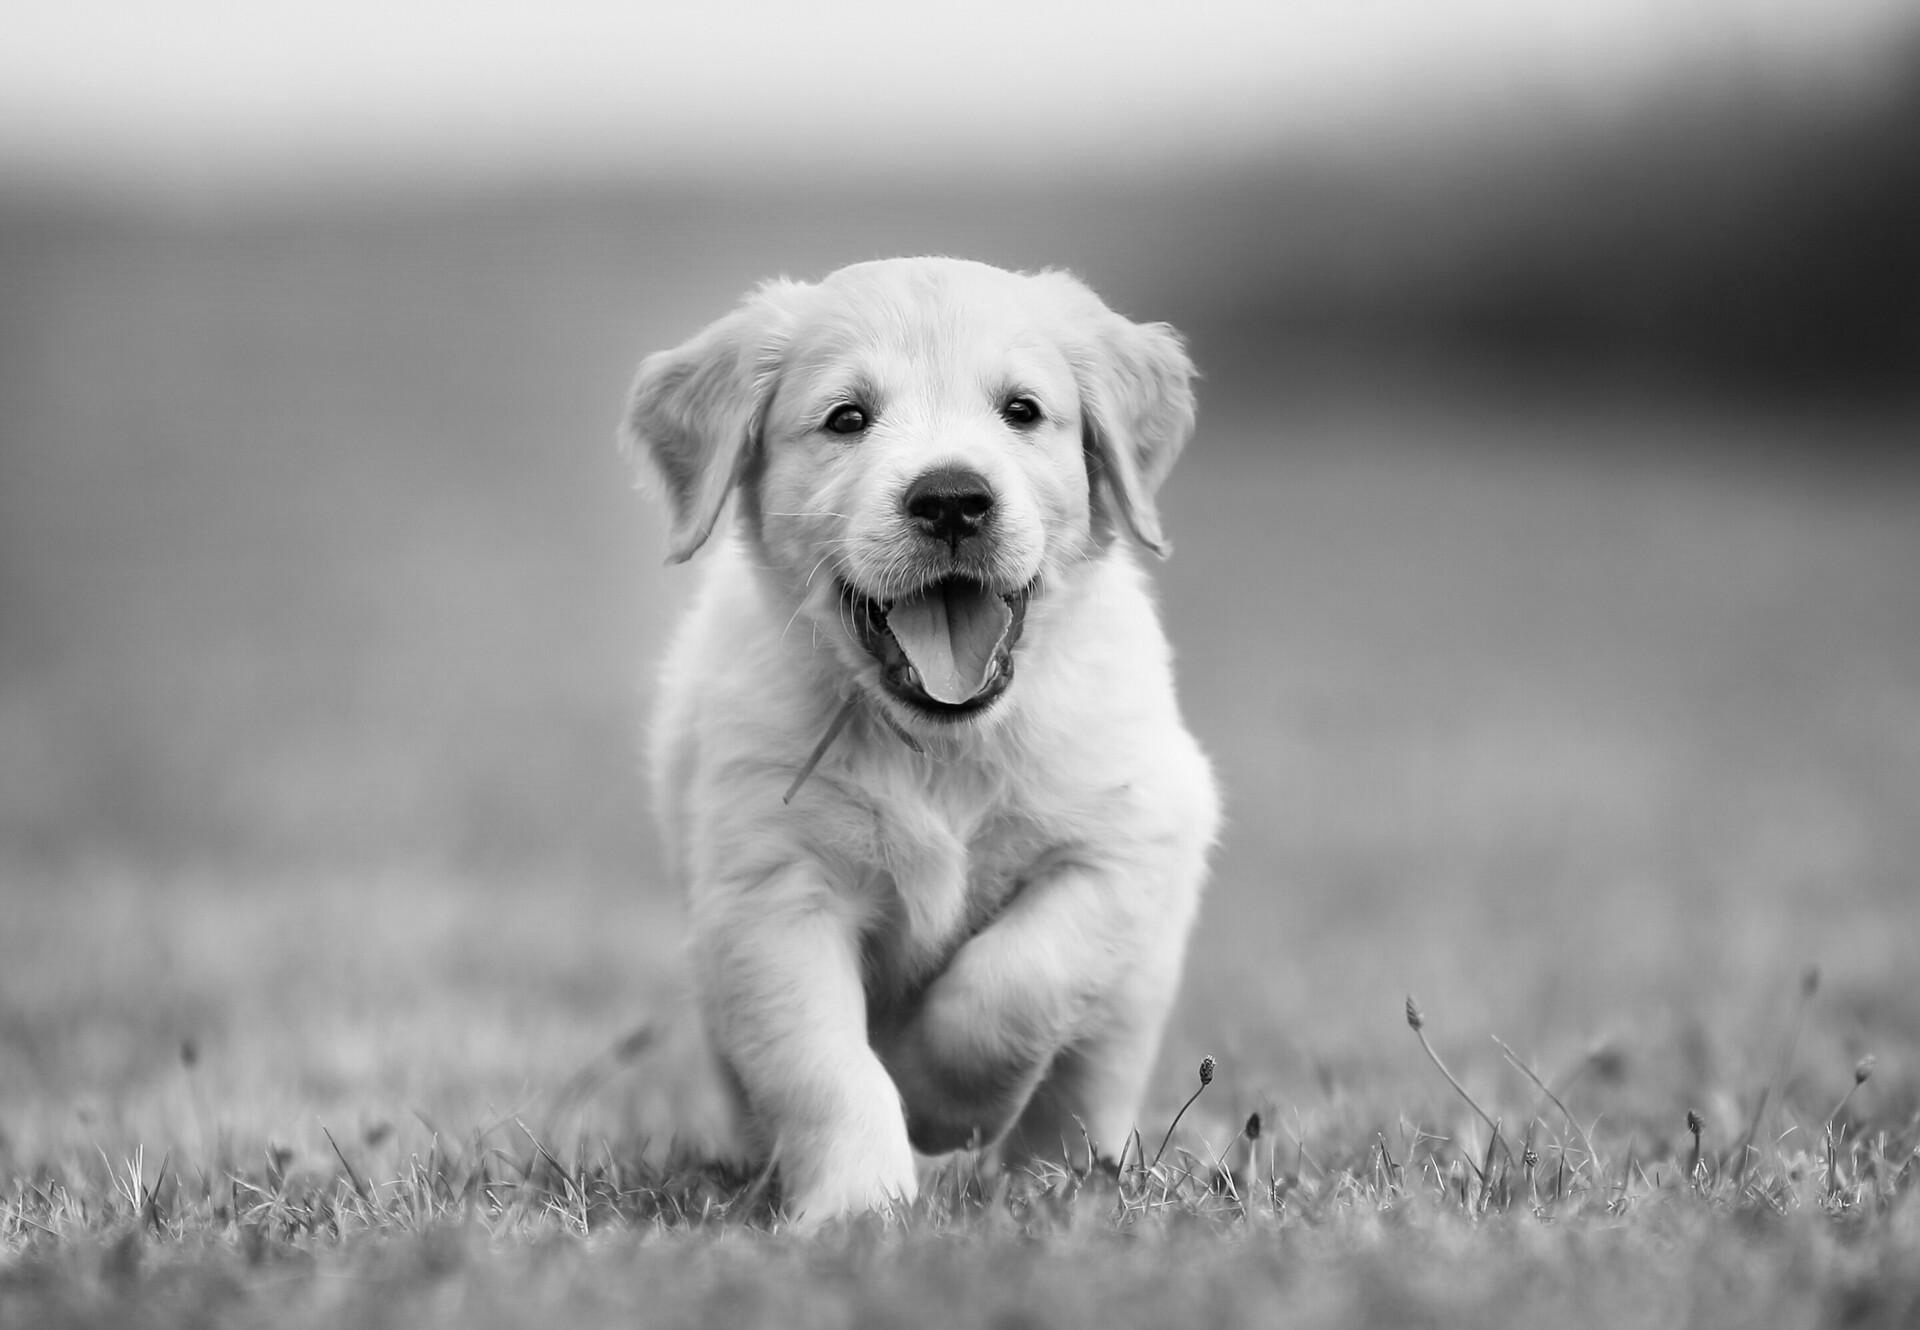

In [52]:
# solución

solucion = cp.asnumpy(cp_out)

Image.fromarray(solucion.astype(np.uint8))

### 3.2. Benchmarking

Veamos cómo queda el rendimiento. Recordemos el tiempo de ejecución en numpy y en cupy.

In [53]:
# Numpy
%timeit gray_np = np.float32(0.2989)*b + np.float32(0.5870)*g + np.float32(0.1140)*r

7.3 ms ± 7.55 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
# Cupy
%timeit gray_cp = cp.float32(0.2989)*d_b + cp.float32(0.5870)*d_g + cp.float32(0.1140)*d_r

149 µs ± 29 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [55]:
# Numba
%timeit rgb_to_gray_kernel[blocks_per_grid, threads_per_block](d_r_1d, d_g_1d, d_b_1d, out_gray); cuda.synchronize()

530 µs ± 3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


CuPy sigue siendo más eficiente, y Numba es mejor que Numpy ya que usa la GPU.

Como ejercicio extra, te propongo que juegues con el número de hilos y el número de bloques para ver si consigues mejorar el tiempo con Numba:

In [56]:
threads_per_block = 256
blocks_per_grid = 86*20

%timeit rgb_to_gray_kernel[blocks_per_grid, threads_per_block](d_r_1d, d_g_1d, d_b_1d, out_gray); cuda.synchronize()

449 µs ± 622 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## 4. Ejercicio propuesto 2: Kernel en 2D

Repite el ejercicio propuesto 1, pero adaptando el kernel para que trabaje con índices de hilos de dos dimensiones. [Aquí](https://numba.pydata.org/numba-doc/dev/cuda/kernels.html#multi-dimensional-blocks-and-grids) puedes ver un ejemplo. También, para practicar, no hagas uso de CuPy, básate en los Numpy arrays que hemos definido antes (r, g y b).

In [57]:
# @FIXME
# def rgb_to_gray_kernel_2d(r, g, b, out):
#     start_x, start_y = cuda.grid(FIXME)
#     stride_x, stride_y = cuda.gridsize(FIXME)

#     for i in range(start_x, r.shape[FIXME], stride_x):
#         for j in range(start_y, r.shape[FIXME], stride_y):
#             out[FIXME] = pixel_rgb_to_gray(FIXME)

In [58]:
# Solución (el Kernel)
@cuda.jit
def rgb_to_gray_kernel_2d(r, g, b, out):
    start_x, start_y = cuda.grid(2)      
    stride_x, stride_y = cuda.gridsize(2) 
    
    for i in range(start_x, r.shape[0], stride_x):
        for j in range(start_y, r.shape[1], stride_y):
            out[i,j] = pixel_rgb_to_gray(r[i,j],g[i,j],b[i,j])

In [59]:
# # copiamos los Numpy arrays a Numba CUDA arrays
# r_device = cuda.FIXME(np.ascontiguousarray(r))
# g_device = cuda.FIXME(np.ascontiguousarray(g))
# b_device = cuda.FIXME(np.ascontiguousarray(b))
# out_2d = cuda.FIXME(r_device)

# threads_per_block_2d = FIXME # lanza bloques de 16x16 hilos
# blocks_per_grid_2d = FIXME  # lanza un grid con 10x10 bloques, lo que daría 100

# rgb_to_gray_kernel_2d[FIXME, FIXME](r_device, g_device, b_device, out_2d);

# solucion_2d = out_2d.copy_to_FIXME()

# Image.fromarray(solucion_2d.astype(np.uint8))

/usr/local/lib64/python3.9/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 100 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


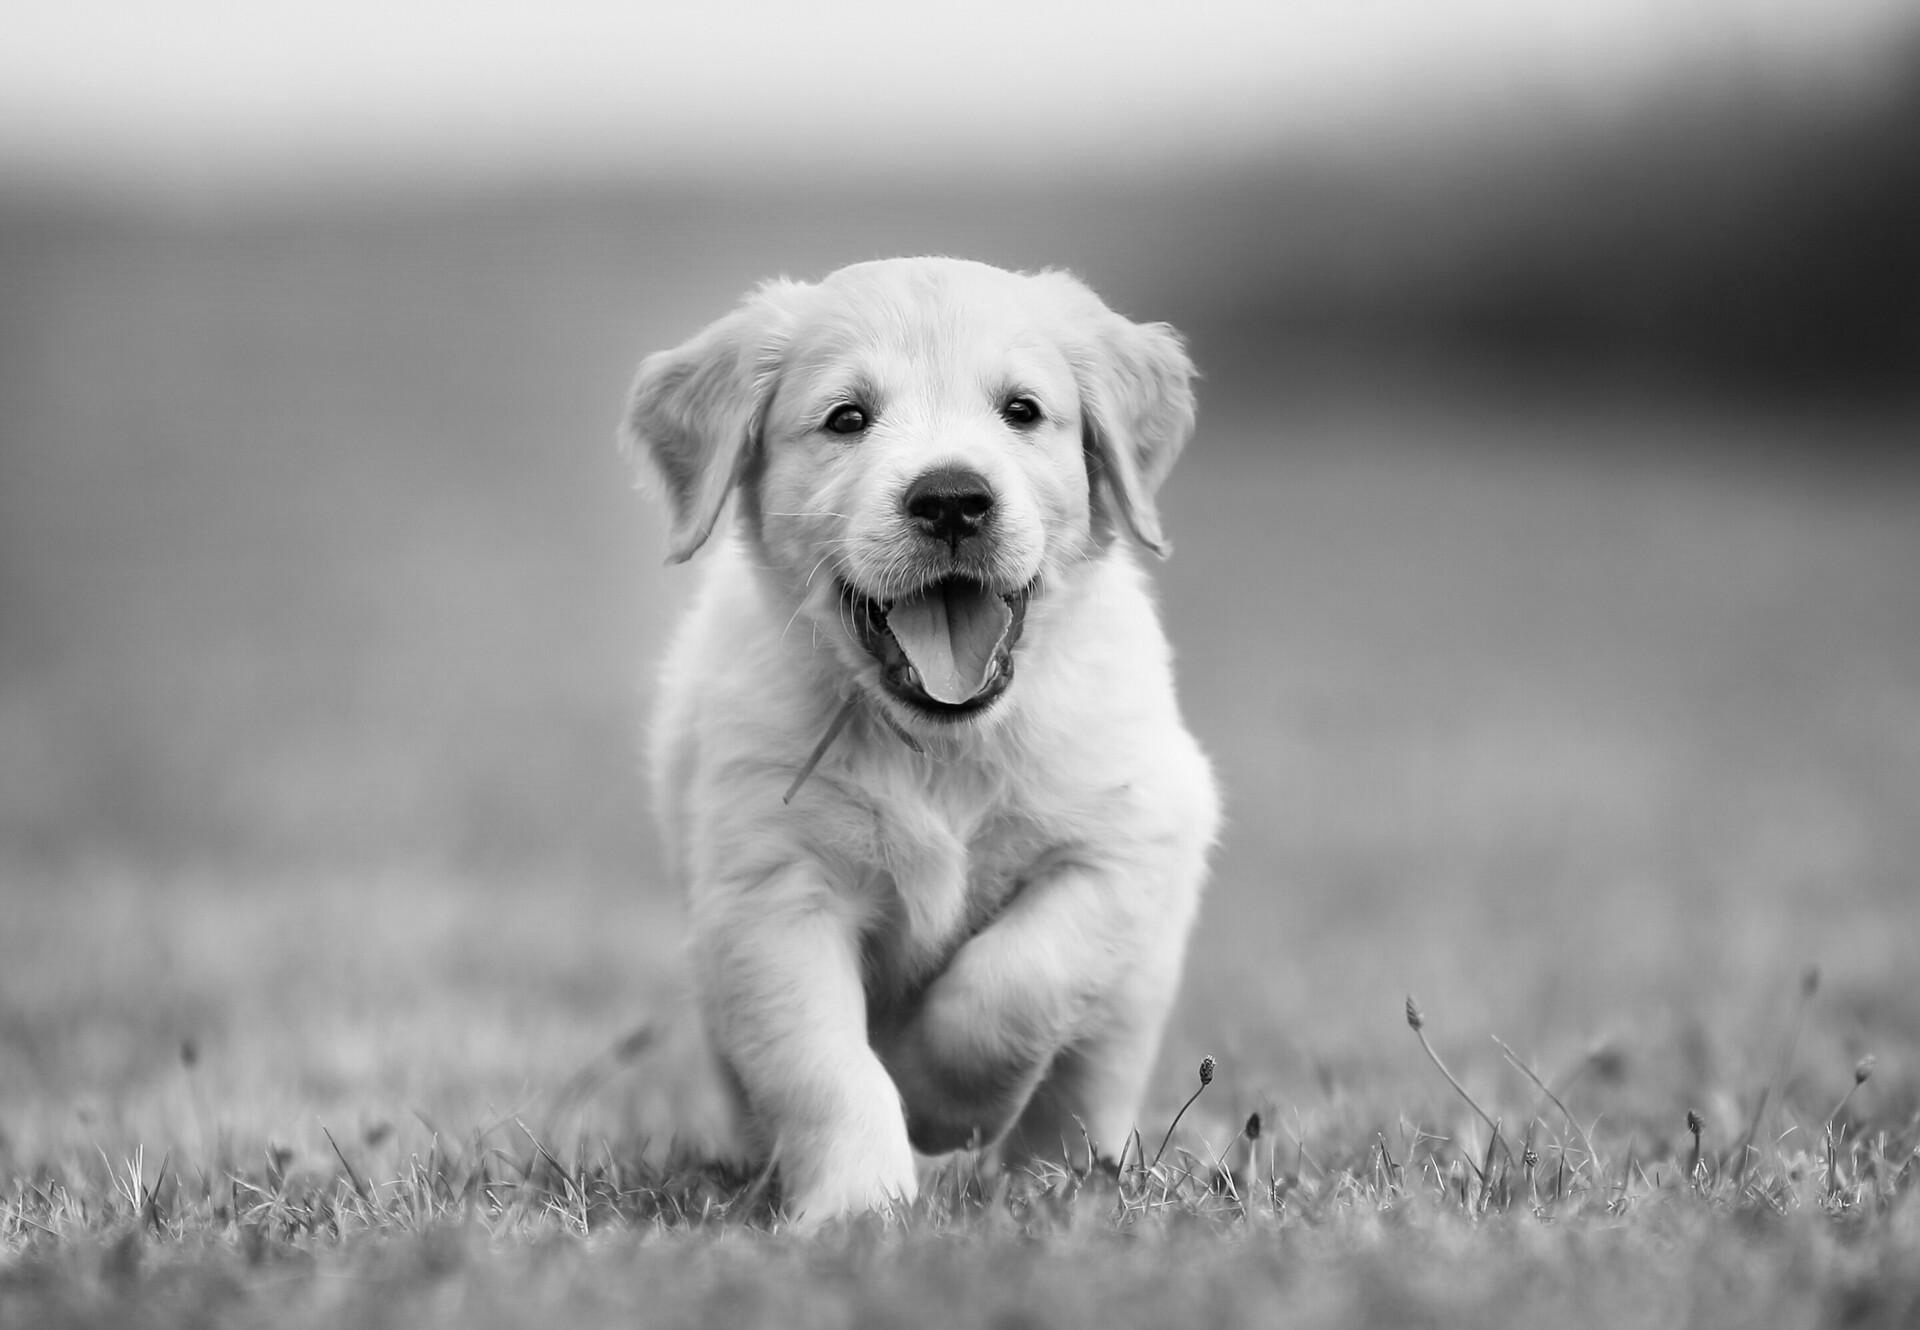

In [60]:
# Solución (la llamada al kernel)

# copiamos los Numpy arrays a Numba CUDA arrays
r_device = cuda.to_device(np.ascontiguousarray(r))
g_device = cuda.to_device(np.ascontiguousarray(g))
b_device = cuda.to_device(np.ascontiguousarray(b))
out_2d = cuda.device_array_like(r_device) 

threads_per_block_2d = (16,16)
blocks_per_grid_2d = (10,10)  #100 > 86, es difícil conseguir exactamente el número, pero no hay problema ya que los bucles se saltan aquellos elemenos fuera de rango

rgb_to_gray_kernel_2d[blocks_per_grid_2d, threads_per_block_2d](r_device, g_device, b_device, out_2d); 

solucion_2d = out_2d.copy_to_host()

Image.fromarray(solucion_2d.astype(np.uint8))


Veamos el rendimiento de este kernel, y juega con el tamaño de grid y de bloque para mejorar el tiempo:

In [61]:
threads_per_block_2d = (16,16)
blocks_per_grid_2d = (10,10)  

%timeit rgb_to_gray_kernel_2d[blocks_per_grid_2d, threads_per_block_2d](r_device, g_device, b_device, out_2d);  cuda.synchronize()

138 µs ± 23.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Curioso! Hemos reducido drásticamente el tiempo del kernel. Pero espera, ¿esto es debido a que estamos trabajando en 2d, o a que estamos trabajando con arrays de Numba y no de CuPy? Bueno, hagamos la prueba. Repite la llamada al kernel que trabaja en 1D, pero esta vez usemos Numba Arrays. Primero aplanemos en Numpy, y luego copiemos a la GPU:

In [62]:
# dr1d = cuda.FIXME(np.ascontiguousarray(r).flatten()) # Copiar a la GPU
# dg1d = cuda.FIXME(np.ascontiguousarray(g).flatten())
# db1d = cuda.FIXME(np.ascontiguousarray(b).flatten())

In [63]:
#Solución

dr1d = cuda.to_device(np.ascontiguousarray(r).flatten())
dg1d = cuda.to_device(np.ascontiguousarray(g).flatten())
db1d = cuda.to_device(np.ascontiguousarray(b).flatten())

In [64]:
%timeit rgb_to_gray_kernel[blocks_per_grid, threads_per_block](dr1d, dg1d, db1d, out_gray); cuda.synchronize

47.5 µs ± 71.8 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


De acuerdo, efectivamente se baja el tiempo de kernel drásticamente. Lección aprendida: aunque le podamos pasar arrays de CuPy a los kernels de Numba, es más eficiente usar Numba Array. CuPy nos puede servir para acelerar operaciones básicas sin que tengamos que crear un Kernel para ello, y lo podemos interoperar con Numba, pero para mejor rendimiento, usemos siempre Numba Arrays.

## 5. Más ejercicios

A continuación propongo más ejercicios para practicar.

* Calcula un histograma sobre la imagen de salida en escala de grises, como se propone al final de este [notebook](https://github.com/miguelamda/cuda-numba/blob/master/5%20-%20Kernels%20de%20CUDA.ipynb)
* Analiza el kernel de ejemplo que calcula la [multiplicación de matrices de Numba](https://numba.pydata.org/numba-doc/dev/cuda/examples.html)